# Data preparation and exploration

## Aim of this notebook

1. Fetch all structures in KLIFS (metadata).
2. Filter dataset by
  - Species
  - DFG conformation (optional)
  - Resolution
  - Quality score
  - Best struture per kinase-PDB pair
3. Save the KLIFS structure IDs for the filtered dataset.

__Note__: The KLIFS data is prepared only on the basis of the structures' metadata from KLIFS. Additional filtering will happen during fingerprint generation, where the actual structural data (coordiantes ect.) are used.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import logging

import pandas as pd
from opencadd.databases.klifs import setup_remote

from src.data.structures import filters, explorer

RDKit WARNING: [16:27:25] Enabling RDKit 2019.09.3 jupyter extensions
INFO:opencadd.databases.klifs.api:If you want to see an non-truncated version of the DataFrames in this module, use `pd.set_option('display.max_columns', 50)` in your notebook.


In [3]:
logging.basicConfig(level=logging.INFO)
pd.set_option("display.max_columns", 50)

In [4]:
SPECIES = "Human"
DFG_CONFORMATION = "in"
RESOLUTION_MAX = 4
QUALITYSCORE_MIN = 4

HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data/processed/"

## Fetch structures (metadata)

In [5]:
remote = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


In [6]:
structures = remote.structures.all_structures()
print(structures.shape)
structures.head()

(11710, 41)


,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,11746,6s9x,-,A,Human,1,AKT1,None,None,KLLGKGTFGKVILYAMKIL_________QNSRPFLTALKYSCFVME...,L1W,-,None,None,out,na,2.6,3.2,9,0,0.959,2.388,False,False,True,False,False,False,False,False,False,False,True,False,True,True,False,20.2643,67.6543,58.3549,None
1,2534,3ocb,-,B,Human,1,AKT1,None,None,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,XM1,-,None,None,in,in,2.7,8.0,0,0,0.778,2.095,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,18.7554,61.4035,57.8721,None
2,11747,6s9w,B,A,Human,1,AKT1,None,None,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,L1Z,-,None,None,out,out,2.3,6.8,0,0,0.965,2.647,False,False,True,False,False,False,False,False,False,False,True,False,True,True,False,20.3600,67.5534,58.5184,None
3,6765,3cqw,B,A,Human,1,AKT1,None,None,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,CQW,-,None,None,in,in,2.0,8.0,0,0,0.779,2.093,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,17.9435,58.2835,52.7742,None
4,2533,3ow4,-,B,Human,1,AKT1,None,None,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,SMY,-,None,None,in,in,2.6,8.0,0,0,0.780,2.104,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,19.1640,61.7818,50.6247,None


## Explore structures in full dataset

### Species, DFG/aC-helix conformations, ligand

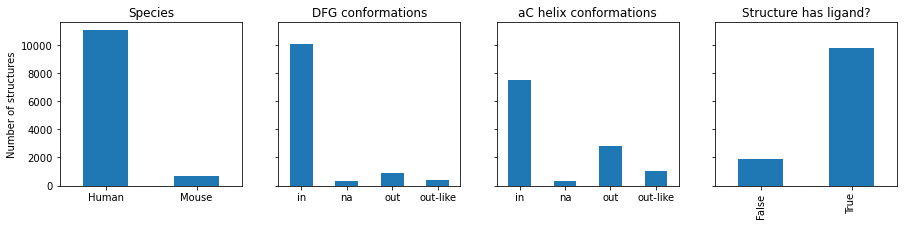

In [7]:
explorer.plot_important_categories(structures);

### Resolution vs. quality score

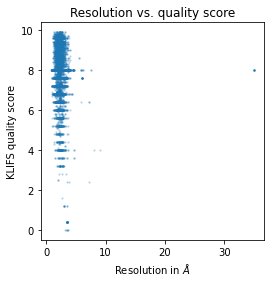

In [8]:
explorer.plot_resolution_vs_qualityscore(structures);

### Number of structures per kinase-PDB pair

How many kinase-PDB pairs are represented by how many structures?

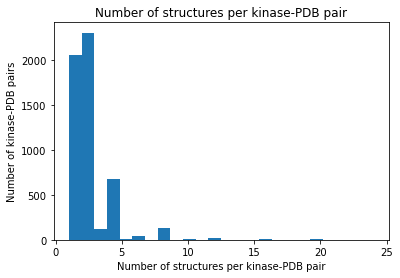

In [9]:
explorer.plot_number_of_structures_per_kinase_pdb_pair(structures);

## Filter structures

In [10]:
structures_filtered = (
    structures.pipe(filters.make_copy)
    .pipe(filters.select_species, SPECIES)
    # .pipe(filters.select_dfg, DFG_CONFORMATION)
    .pipe(filters.select_resolution, RESOLUTION_MAX)
    .pipe(filters.select_qualityscore, QUALITYSCORE_MIN)
    .pipe(filters.select_best_pdb_kinase_pairs)
)
structures_filtered.reset_index(inplace=True, drop=True)

INFO:kissim.dataset.filters:make_copy                       11710 structures (-1 day, 23:59:59.998703s)
INFO:kissim.dataset.filters:select_species                  11050 structures (-1 day, 23:59:59.995662s)
INFO:kissim.dataset.filters:select_resolution               10773 structures (-1 day, 23:59:59.996302s)
INFO:kissim.dataset.filters:select_qualityscore             10687 structures (-1 day, 23:59:59.996084s)
INFO:kissim.dataset.filters:select_best_pdb_kinase_pairs     4944 structures (-1 day, 23:59:59.979564s)


## Save filtered structures

In [11]:
structures_filtered["structure.klifs_id"].to_csv(
    DATA / "structure_klifs_ids.txt", index=None, header=None
)